In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['axes.grid'] = False
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (ModelCheckpoint, LearningRateScheduler, Callback)
from tensorflow.keras.metrics import AUC

In [2]:
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
tqdm.pandas()
from tokenizers import Tokenizer, models

In [3]:
DATA_FOLDER = "../../data"
DATA_TRANSLATED = "../../data"

In [5]:
import sys
sys.path.append("../utils/")
from helpers import regular_encode, roc_auc, fast_encode, build_lrfn

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

In [7]:
train1 = pd.read_csv(DATA_TRANSLATED + "/jigsaw-toxic-comment-train-google-it-cleaned.csv")
train2 = pd.read_csv(DATA_TRANSLATED + "/jigsaw-toxic-comment-train-google-fr-cleaned.csv")
train3 = pd.read_csv(DATA_TRANSLATED + '/jigsaw-toxic-comment-train-google-es-cleaned.csv')
train4 = pd.read_csv(DATA_TRANSLATED + '/jigsaw-toxic-comment-train-google-tr-cleaned.csv')
train5 = pd.read_csv(DATA_TRANSLATED + '/jigsaw-toxic-comment-train-google-pt-cleaned.csv')
train6 = pd.read_csv(DATA_TRANSLATED + '/jigsaw-toxic-comment-train-google-ru-cleaned.csv')
valid = pd.read_csv(DATA_FOLDER + '/validation.csv')
test = pd.read_csv(DATA_FOLDER + '/test.csv')

In [8]:
n_train = 35000
train = pd.concat([
    train1[['comment_text', 'toxic']].sample(n=n_train, random_state=1), 
    train2[['comment_text', 'toxic']].sample(n=n_train, random_state=2), 
    train3[['comment_text', 'toxic']].sample(n=n_train, random_state=3), 
    train4[['comment_text', 'toxic']].sample(n=n_train, random_state=4), 
    train5[['comment_text', 'toxic']].sample(n=n_train, random_state=5), 
    train6[['comment_text', 'toxic']].sample(n=n_train, random_state=6),
])

In [9]:
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 224
MODEL = 'jplu/tf-xlm-roberta-large'

In [10]:
tokenizer =AutoTokenizer.from_pretrained(MODEL)

In [11]:
%%time
x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test  = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

CPU times: user 1min 50s, sys: 310 ms, total: 1min 50s
Wall time: 1min 50s


In [43]:
BATCH_SIZE = 64
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
#     .shuffle(2048)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [13]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [14]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(64, activation='relu')(cls_token)
    out = Dropout(0.35)(out)
    out = Dense(1, activation='sigmoid')(out)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[AUC()])
    return model

In [15]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=MAX_LEN)


CPU times: user 1min 42s, sys: 17.4 s, total: 2min
Wall time: 10min 8s


In [16]:
MODEL_PATH = '../models/savedmodels/model09365.h5'
model.load_weights(MODEL_PATH)

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 224)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 224, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout_74 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 559,956,097
Trainable params: 559,956,097
Non-trainable params: 0
_______________________________________________

In [17]:
sub = pd.read_csv(DATA_FOLDER + '/sample_submission.csv')

In [18]:
valid_pred = model.predict(valid_dataset, verbose=1)

125/125 [==============================] - 184s 1s/step


In [19]:
# add a prediction column in the original data
valid['pred'] = valid_pred

In [98]:
uncertain_toxic = pd.concat([
    valid[["comment_text", "toxic", "pred"]].query("toxic == 1 & pred < 0.65"),
    valid[["comment_text", "toxic", "pred"]].query("toxic == 1 & pred > 0.65").sample(frac=0.2, random_state=0)
])

In [99]:
uncertain_nontoxic = pd.concat([
    valid[["comment_text", "toxic", "pred"]].query("toxic == 0 & pred > 0.2 & pred < 0.65"),
    valid[["comment_text", "toxic", "pred"]].query("toxic == 0 & pred <= 0.2").sample(frac=0.2, random_state=0)
])

In [100]:
uncertain = pd.concat([uncertain_nontoxic, uncertain_toxic], axis=0)
uncertain.drop(columns=['pred'], inplace=True)
uncertain.to_csv(DATA_FOLDER + "/valid_uncertain.csv", index=False)

In [103]:
uncertain.tail()

,comment_text,toxic
2552,Baskalarinin saatlerce calisip hazirladigini s...,1
7816,Siz kardeş kardeş dünyadan silineceksiniz zate...,1
3188,puto deja de borrar cosas que ni sabes que ex...,1
6288,"Andate a fare in culo, Paolini è un grande. Pa...",1
4619,"CARI HATERS DI MERDA, VI SPIEGO UNA COSA. ¨È U...",1


In [45]:
n_steps = train.shape[0] // BATCH_SIZE
train_pred = model.predict(train_dataset, steps=n_steps, verbose=1)

3281/3281 [==============================] - 5007s 2s/step


In [50]:
len(train_pred)
# train.shape

209984

In [52]:
y_train_true = y_train[:len(train_pred)]

In [83]:
train = train.iloc[:len(train_pred), :]
train['pred'] = train_pred

In [93]:
uncertain_toxic = pd.concat([
    train[["comment_text", "toxic", "pred"]].query("toxic == 1 & pred < 0.65"),
    train[["comment_text", "toxic", "pred"]].query("toxic == 1 & pred > 0.65").sample(frac=0.2, random_state=0)
])

In [94]:
uncertain_nontoxic = pd.concat([
    train[["comment_text", "toxic", "pred"]].query("toxic == 0 & pred > 0.2 & pred < 0.65"),
    train[["comment_text", "toxic", "pred"]].query("toxic == 0 & pred <= 0.2").sample(frac=0.2, random_state=0)
])

In [95]:
uncertain = pd.concat([uncertain_nontoxic, uncertain_toxic], axis=0)
uncertain.drop(columns=['pred'], inplace=True)
uncertain.shape

(70017, 2)

In [97]:
uncertain.to_csv(DATA_FOLDER + "/train_uncertain.csv", index=False)

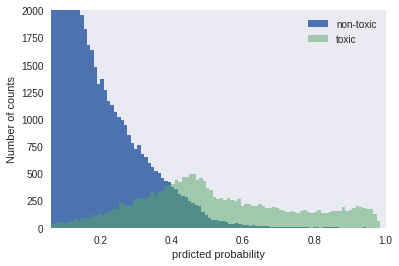

In [58]:
plt.hist(train_pred[y_train_true == 0], bins=100, label="non-toxic")
plt.hist(train_pred[y_train_true == 1], bins=100, alpha=0.5, label="toxic")
plt.xlabel("prdicted probability")
plt.ylabel("Number of counts")
plt.xlim(0.06,1)
plt.ylim(0,2000)
plt.legend();

In [78]:
(train_pred[y_train_true == 0] > 0.2).sum()

20417

In [81]:
(train_pred[y_train_true == 1] > 0.65).sum()

5446

In [59]:
auc_score_train = roc_auc_score(y_train_true, train_pred)
auc_score_trainauc_score = roc_auc_score(y_valid, valid_pred)

0.9743259544719771

In [20]:
auc_score = roc_auc_score(y_valid, valid_pred)
# valid_pred

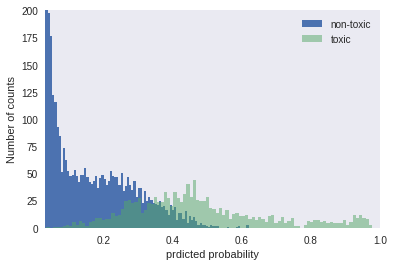

In [46]:
plt.hist(valid_pred[y_valid == 0], bins=100, label="non-toxic")
plt.hist(valid_pred[y_valid == 1], bins=100, alpha=0.5, label="toxic")
plt.xlabel("prdicted probability")
plt.ylabel("Number of counts")
plt.xlim(0.03,1)
plt.ylim(0,200)
plt.legend();

In [24]:
mask = (valid_pred[y_valid == 1] < 0.36)
mask.sum()

380

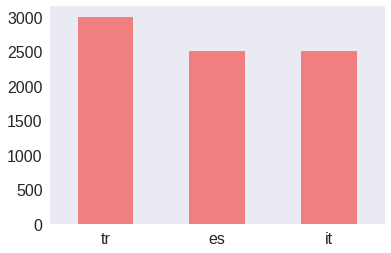

In [27]:
valid.lang.value_counts().plot.bar(rot=0, fontsize=16, color='lightcoral')

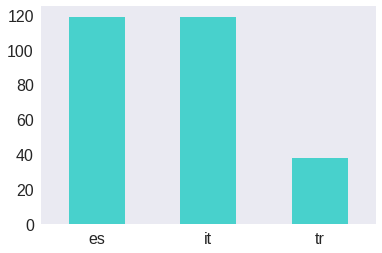

In [39]:
valid[["lang", "toxic", "pred"]].query("toxic == 0 & pred > 0.36").lang.value_counts().plot.bar(rot=0, fontsize=16, color='mediumturquoise')

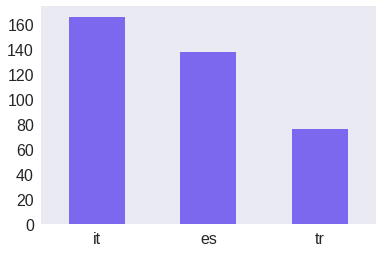

In [32]:
valid[["lang", "toxic", "pred"]].query("toxic == 1 & pred < 0.36").lang.value_counts().plot.bar(rot=0, fontsize=16, color='mediumslateblue')

In [35]:
(valid_pred[y_valid == 0] > 0.15).sum()

1577

In [36]:
print(max(valid_pred[y_valid == 1]))
max(valid_pred[y_valid == 0])

[0.97750753]


array([0.61970454], dtype=float32)

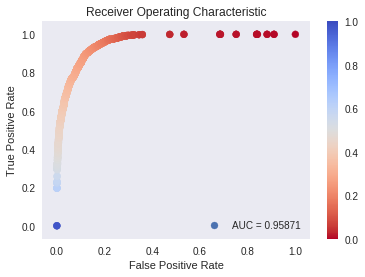

In [37]:
fpr, tpr, threshold = roc_curve(y_valid, valid_pred)
cm = plt.cm.get_cmap('coolwarm_r')
plt.title('Receiver Operating Characteristic')
sc = plt.scatter(fpr, tpr, c=threshold, cmap=cm, label = f'AUC = {auc_score:.5f}')
plt.colorbar(sc)
plt.legend(loc = 'lower right')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.clim(0,1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()